In [1]:
import collections
from typing import List
import numpy as np
import math
import torch.cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import copy

from utils.logger import Logger

    

from utils.io_utils import save_code
from utils.logger import Logger

In [2]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [4]:
state_dim = 1
actions = [-10,0,10]

In [5]:
Transition = collections.namedtuple(
    "Transition", ["state", "action_0", "action_1", "pref", "chosen_probs"]
)


def sigmoid(x: float):
    return 1.0 / (1.0 + math.exp(-x))

class NonMonotonicScalarToVectorNN(nn.Module):
    def __init__(self):
        super(NonMonotonicScalarToVectorNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)     # Input layer (1 -> 10)
        self.fc2 = nn.Linear(10, 20)    # Hidden layer (10 -> 20)
        self.fc3 = nn.Linear(20, 2)     # Output layer (20 -> 2)      
    def forward(self, x):
        x = torch.tanh(self.fc1(x))      # Using sin activation for non-monotonicity
        x = torch.tanh(self.fc2(x))     # Tanh activation adds more non-linearity
        x = self.fc3(x)                 # Output layer
        return x
        

def get_score(action_one,action_two,feature_func):
    feature_one = feature_func(torch.tensor([[action_one]], dtype=torch.float))[0].detach().numpy()
    feature_two = feature_func(torch.tensor([[action_two]], dtype=torch.float))[0].detach().numpy()
    score_param =  np.array([[0.0, -1.0],[1, 0]], np.float32) 
    score = feature_one@score_param@feature_two
    return score

def get_p(action_one,action_two,feature_func):
    feature_one = feature_func(torch.tensor([[action_one]], dtype=torch.float))[0].detach().numpy()
    feature_two = feature_func(torch.tensor([[action_two]], dtype=torch.float))[0].detach().numpy()
    score_param =  np.array([[0.0, -1.0],[1, 0]], np.float32) 
    score = feature_one@score_param@feature_two 
    
    temperature = 0.1
    p = 1 / (1 + np.exp(-score / temperature))
   
    return p

        
        
def collect_preference_data(
    actions:np.ndarray,
    sample_size: int,
) -> List[Transition]:
    pref_dataset = []
    actions = actions
    cur_state = np.array([0])   
    feature_func = NonMonotonicScalarToVectorNN()
    
    p_list = np.zeros([len(actions),len(actions)])
    for i in range(len(actions)):
        for j in range(len(actions)):
            action_one = actions[i]
            action_two = actions[j]
            p = get_p(action_one,action_two,feature_func)
            if i==j:
                assert p==0.5
            p_list[i][j] = p
            
    for i in range(sample_size):
        idx_one, idx_two = np.random.choice(len(actions), 2, replace=False)
        action_one = actions[idx_one]
        action_two = actions[idx_two]
        
        bernoulli_param = p_list[idx_one][idx_two]
        
        if np.random.random() < bernoulli_param:  
            transition = Transition(
                cur_state, action_one, action_two, 0, p_list[idx_one][idx_two]
            )
        else:
            transition = Transition(
                cur_state, action_two, action_one, 1, p_list[idx_two][idx_one]
            )
        pref_dataset.append(transition)

           
    return pref_dataset,p_list

### Collect data

In [6]:
torch.manual_seed(5)
pref_dataset, p_list = collect_preference_data(actions,60)

In [7]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [8]:
pref_dataset

[Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [9]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

In [10]:
len(pref_dataset)

60

In [11]:
positive_actions

tensor([0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2,
        2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2,
        0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0])

In [12]:
negative_actions

tensor([1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1,
        1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1])

In [13]:
# check transition
import itertools

def check_cyclic_order(matrix):
    items = [str(i) for i in actions]
    # Generate all permutations of the items
    for perm in itertools.permutations(items):
        # Extract preferences based on the current permutation
        if (matrix[items.index(perm[0])][items.index(perm[1])] > 0.5 and
            matrix[items.index(perm[1])][items.index(perm[2])] > 0.5 and
            matrix[items.index(perm[2])][items.index(perm[0])] > 0.5):
            return True, perm  # Found a cyclic order
    return False, None  # No cyclic order found
check_cyclic_order(p_list)

(True, ('-10', '0', '10'))

In [14]:
def check_data_consistency(pref_dataset):
    consistent = 0
    total = len(pref_dataset)
    
    for t in pref_dataset:
      
        if (t.chosen_probs > 0.5):
            consistent += 1
    
    return consistent / total

check_data_consistency(pref_dataset)

0.8

RLHF

In [15]:
class RewardModel(nn.Module):

    def __init__(
        self,
        state_dim,
        actions,
        action_feature_extractor: nn.Module = None,
        hidden_dim: int = 128,
        num_layers: int = 2,
        device: str = "cpu",
    ):
        super().__init__()
        self.device = torch.device(device)

        if action_feature_extractor is None:
            action_feature_extractor = [
                nn.Linear(len(actions), hidden_dim),
                nn.Tanh(),
            ]
            for _ in range(num_layers - 1):
                action_feature_extractor.append(nn.Linear(hidden_dim, hidden_dim))
                action_feature_extractor.append(nn.Tanh())
        self.action_feature_extractor = nn.Sequential(*action_feature_extractor).to(self.device)

        self.predict_layer = nn.Linear(hidden_dim , 1).to(self.device)

    def forward(self, state: torch.tensor, action: torch.tensor) -> torch.tensor:
        assert len(state.shape) == len(action.shape)
        assert torch.all(action >= 0) and torch.all(action <= 1), f"{action}"

        
        action = torch.as_tensor(action, dtype=torch.float32, device=self.device)

       
        ha = self.action_feature_extractor(action)

        rew = self.predict_layer(ha)
       
        return rew
    


class MaximumLikelihoodEstimator:
    def __init__(
        self,
        actions: np.ndarray,
        reward_model: nn.Module,
        learning_rate: float = 1e-3,
        weight_decay: float = 0.0,
        batch_size: int = 64,
        logger: Logger = None,
    ):
        self.actions = actions
        self.reward_model = reward_model
        self.batch_size = batch_size
        self.logger = logger

        self.optimizer = torch.optim.AdamW(
            self.reward_model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

    def optimize_one_epoch(self, states, positive_actions, negative_actions):
        total_loss = 0.0
        total_acc = 0.0

        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()

            _states = states[i : i + self.batch_size]
            _positive_actions = positive_actions[i : i + self.batch_size]
            _negative_actions = negative_actions[i : i + self.batch_size]

            _positive_actions = F.one_hot(
                _positive_actions, num_classes=len(self.actions)
            )
            _negative_actions = F.one_hot(
                _negative_actions, num_classes=len(self.actions)
            )
            
         
            _states = _states.unsqueeze(1) if _states.dim() == 1 else _states
            

            positive_rews = self.reward_model(_states, _positive_actions)
            negative_rews = self.reward_model(_states, _negative_actions)

            loss = -torch.log(torch.sigmoid(positive_rews - negative_rews)).mean()
            loss.backward()
            self.optimizer.step()

            acc = (positive_rews > negative_rews).float().mean()

            total_loss += loss.item()
            total_acc += acc.item()
            k += 1

        return total_loss / k, total_acc / k

    def optimize(self, states, positive_actions, negative_actions, num_epochs):
        for epoch in range(num_epochs):
            loss, acc = self.optimize_one_epoch(
                states, positive_actions, negative_actions
            )
            if self.logger:
                if epoch % 2 == 0:
                    self.logger.info(
                        f"[Reward] Epoch {epoch} loss: {loss:.4f} acc: {acc:.2f}"
                    )


In [16]:
learned_reward_model = RewardModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [17]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [18]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-11-12 09:22:14,314 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 0 loss: 0.6915 acc: 0.52
2024-11-12 09:22:14,320 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 2 loss: 0.6910 acc: 0.52
2024-11-12 09:22:14,326 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 4 loss: 0.6905 acc: 0.52
2024-11-12 09:22:14,331 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 6 loss: 0.6902 acc: 0.52
2024-11-12 09:22:14,336 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 8 loss: 0.6898 acc: 0.55
2024-11-12 09:22:14,341 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 10 loss: 0.6896 acc: 0.55
2024-11-12 09:22:14,347 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 12 loss: 0.6894 acc: 0.55
2024-11-12 09:22:14,352 - /tmp/ipykernel_3369283/3626585618.py[line:107] - INFO: [Reward] Epoch 14 loss: 0.6892 acc: 0.55
2024-11-12 09:22:14,356 - /tm

In [60]:
class PolicyModel(nn.Module):
    def __init__(
        self,
        state_dim: int,
        actions: np.ndarray,
        hidden_dim: int = 128,
        num_layers: int = 2,
        device: str = "cpu",
    ):
        super().__init__()

        self.state_dim = state_dim
        self.action_num = len(actions)

        self.device = torch.device(device)

        network = [nn.Linear(state_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            network.append(nn.Linear(hidden_dim, hidden_dim))
            network.append(nn.ReLU())
        network.append(nn.Linear(hidden_dim, self.action_num))

        self.network = nn.Sequential(*network)

    def forward(self, state: torch.tensor) -> torch.tensor:
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device)
        logits = self.network(state)
        return torch.softmax(logits, dim=-1)


class UniformPolicyModel(nn.Module):
    def __init__(self, action_num: int, device: str = "cpu"):
        super().__init__()
        self.action_num = action_num
        self.device = torch.device(device)

    def forward(self, state: torch.tensor) -> torch.tensor:
        logits = torch.zeros(
            [len(state), self.action_num], dtype=torch.float32, device=self.device
        )
        return torch.softmax(logits, dim=-1)

#TODO: other ref models       


In [20]:
class PolicyGradientOptimizer:
    def __init__(
        self,
        policy: nn.Module,
        reward_model: nn.Module,
        ref_policy: nn.Module,  # Uniform policy
        learning_rate: float = 1e-3,
        batch_size: int = 64,
        logger: Logger = None,
    ):
        self.policy = policy
        self.reward_model = reward_model
        self.ref_policy = ref_policy
        self.batch_size = batch_size
        self.logger = logger
        
        self.optimizer = torch.optim.AdamW(
            self.policy.parameters(), lr=learning_rate
        )

    def optimize_one_epoch(self, states):
        total_loss = 0.0
        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()
            
            _states = states[i : i + self.batch_size]
           
            distributions = self.policy(_states)
            ref_distributions = self.ref_policy(_states)
            
            
            rewards = self.reward_model(_states, distributions)
            ref_rewards = self.reward_model(_states, ref_distributions)
            
            
            loss = -torch.sum(distributions * rewards, dim=-1).mean()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            k += 1
            
        return total_loss / k, rewards.mean().item(), ref_rewards.mean().item()

    def optimize(self, states, num_epochs=100):
        for epoch in range(num_epochs):
            loss, reward, ref_reward = self.optimize_one_epoch(states)
            if epoch % 2 == 0:
                if self.logger:
                    self.logger.info(
                        f"[Policy] Epoch {epoch} "
                        f"loss: {loss:.4f} "
                        f"reward: {reward:.4f} "
                        f"ref_reward: {ref_reward:.4f} "
                        f"improvement: {(reward-ref_reward)/abs(ref_reward):.2%}"
                    )


In [21]:
# pg
policy = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [61]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

In [72]:
ref_policy(torch.tensor([[0.0]]))

tensor([[0., 0., 1.]], device='cuda:0')

In [23]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 

In [24]:
policy_optimizer = PolicyGradientOptimizer(
    policy=policy,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    logger=logger
)

In [25]:
policy_optimizer.optimize(states=states, num_epochs=100)

2024-11-12 09:22:14,460 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 0 loss: -0.2123 reward: 0.2123 ref_reward: 0.1991 improvement: 6.59%
2024-11-12 09:22:14,468 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 2 loss: -0.2176 reward: 0.2176 ref_reward: 0.1991 improvement: 9.25%
2024-11-12 09:22:14,475 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 4 loss: -0.2228 reward: 0.2228 ref_reward: 0.1991 improvement: 11.88%
2024-11-12 09:22:14,482 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 6 loss: -0.2282 reward: 0.2282 ref_reward: 0.1991 improvement: 14.58%


2024-11-12 09:22:14,489 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 8 loss: -0.2337 reward: 0.2337 ref_reward: 0.1991 improvement: 17.35%
2024-11-12 09:22:14,496 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 10 loss: -0.2393 reward: 0.2393 ref_reward: 0.1991 improvement: 20.18%
2024-11-12 09:22:14,502 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 12 loss: -0.2450 reward: 0.2450 ref_reward: 0.1991 improvement: 23.05%
2024-11-12 09:22:14,509 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 14 loss: -0.2507 reward: 0.2507 ref_reward: 0.1991 improvement: 25.91%
2024-11-12 09:22:14,515 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 16 loss: -0.2564 reward: 0.2564 ref_reward: 0.1991 improvement: 28.75%
2024-11-12 09:22:14,522 - /tmp/ipykernel_3369283/201659581.py[line:51] - INFO: [Policy] Epoch 18 loss: -0.2619 reward: 0.2619 ref_reward: 0.1991 improvement: 31.53%
2024-11-12 

In [54]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3088], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1832], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0883], device='cuda:0', grad_fn=<ViewBackward0>)


In [26]:
# output the probabilities of each action from the learned policy
test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    action_probs = policy(test_state)
    action_probs = action_probs.cpu().numpy()[0]  

actions = [-10, 0, 10]  
for action, prob in zip(actions, action_probs):
    print(f"P(action={action}) = {prob:.3f}")

# output the probabilities of each action from the reference policy
ref_probs = ref_policy(test_state).cpu().numpy()[0]
print("\nUniform policy probabilities:")
for action, prob in zip(actions, ref_probs):
    print(f"P(action={action}) = {prob:.3f}")

P(action=-10) = 0.993
P(action=0) = 0.003
P(action=10) = 0.004

Uniform policy probabilities:
P(action=-10) = 0.333
P(action=0) = 0.333
P(action=10) = 0.333


## DPO

In [27]:
class DirectPreferenceOptimizer:
    def __init__(
        self,
        policy: nn.Module,
        ref_policy: nn.Module,
        learning_rate: float = 1e-3,
        weight_decay: float = 0.0,
        batch_size: int = 64,
        beta: float = 1.0,
        logger: Logger = None,
    ):
        self.policy = policy
        self.ref_policy = ref_policy
        
        self.batch_size = batch_size
        self.beta = beta
        self.logger = logger

        self.optimizer = torch.optim.AdamW(
            self.policy.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

    def optimize_one_epoch(
        self,
        states: torch.tensor,
        positive_actions: torch.tensor,
        negative_actions: torch.tensor,
    ):
        total_loss = 0.0
        total_gradient_norm = 0.0
        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()

            _states = states[i : i + self.batch_size]
            distributions = self.policy(_states)
            ref_distributions = self.ref_policy(_states)

            _positive_actions = positive_actions[i : i + self.batch_size]
            _negative_actions = negative_actions[i : i + self.batch_size]

            pi_positive_logprobs = distributions[
                np.arange(len(_states)), _positive_actions
            ]
            pi_negative_logprobs = distributions[
                np.arange(len(_states)), _negative_actions
            ]

            ref_positive_logprobs = ref_distributions[
                np.arange(len(_states)), _positive_actions
            ]
            ref_negative_logprobs = ref_distributions[
                np.arange(len(_states)), _negative_actions
            ]

            pi_log_ratios = pi_positive_logprobs - pi_negative_logprobs
            ref_log_ratios = ref_positive_logprobs - ref_negative_logprobs

            log_ratios = pi_log_ratios - ref_log_ratios

            loss = -F.logsigmoid(self.beta * log_ratios).mean()

            total_loss += loss.item()

            loss.backward()

            gradient_norm = 0.0
            for p in self.policy.parameters():
                param_norm = p.grad.detach().data.norm(2)
                gradient_norm += param_norm.item() ** 2
            gradient_norm = gradient_norm**0.5
            total_gradient_norm += gradient_norm

            self.optimizer.step()

            k += 1

        return total_loss / k, total_gradient_norm / k

    def optimize(
        self,
        states: torch.tensor,
        positive_actions: torch.tensor = None,
        negative_actions: torch.tensor = None,
        num_epochs: int = 10,
    ):
        eval_epoch_interval = 5
        for epoch in range(num_epochs):
            loss, gradient_norm = self.optimize_one_epoch(
                states, positive_actions, negative_actions
            )
            if epoch % eval_epoch_interval == 0:
                if self.logger:
                    self.logger.info(
                        f"[Policy] Epoch: {epoch} loss: {loss:.4f} grad norm: {gradient_norm:.4f} "
                    )


In [28]:
policy2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [29]:
dpo_optimizer = DirectPreferenceOptimizer(
    policy=policy2,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger
)

In [30]:
dpo_optimizer.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
)

2024-11-12 09:22:14,970 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Policy] Epoch: 0 loss: 0.6942 grad norm: 0.0433 
2024-11-12 09:22:14,988 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Policy] Epoch: 5 loss: 0.6908 grad norm: 0.0258 
2024-11-12 09:22:15,003 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Policy] Epoch: 10 loss: 0.6893 grad norm: 0.0121 
2024-11-12 09:22:15,019 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Policy] Epoch: 15 loss: 0.6888 grad norm: 0.0023 
2024-11-12 09:22:15,034 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Policy] Epoch: 20 loss: 0.6889 grad norm: 0.0062 
2024-11-12 09:22:15,049 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Policy] Epoch: 25 loss: 0.6889 grad norm: 0.0065 
2024-11-12 09:22:15,064 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Policy] Epoch: 30 loss: 0.6889 grad norm: 0.0047 
2024-11-12 09:22:15,079 - /tmp/ipykernel_3369283/3860663475.py[line:94] - INFO: [Poli

In [31]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy2(test_state)
    print("\nLearned policy probabilities:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")


Learned policy probabilities:
P(action=-10) = 0.475
P(action=0) = 0.215
P(action=10) = 0.310


## SPPO

In [32]:
policy3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [33]:
class SelfPlayPreferenceOptimizer:
    def __init__(
        self,
        policy: nn.Module,
        ref_policy: nn.Module,
        learning_rate: float = 1e-3,
        weight_decay: float = 0.0,
        batch_size: int = 64,
        eta: float = 1e-4,
        logger: Logger = None,
    ):
        self.policy = policy
        self.ref_policy = ref_policy
        
        self.batch_size = batch_size
        self.eta = eta
        self.logger = logger

        self.optimizer = torch.optim.AdamW(
            self.policy.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

    def optimize_one_epoch(
        self,
        states: torch.tensor,
        positive_actions: torch.tensor,
        negative_actions: torch.tensor,
        chsoen_probs: torch.tensor,
    ):
        total_loss = 0.0
        total_gradient_norm = 0.0
        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()

            _states = states[i : i + self.batch_size]
            distributions = self.policy(_states)
            ref_distributions = self.ref_policy(_states)

            _positive_actions = positive_actions[i : i + self.batch_size]
            _negative_actions = negative_actions[i : i + self.batch_size]

            pi_positive_logprobs = distributions[
                np.arange(len(_states)), _positive_actions
            ]
            pi_negative_logprobs = distributions[
                np.arange(len(_states)), _negative_actions
            ]

            ref_positive_logprobs = ref_distributions[
                np.arange(len(_states)), _positive_actions
            ]
            ref_negative_logprobs = ref_distributions[
                np.arange(len(_states)), _negative_actions
            ]

            
            square_log_w = ((pi_positive_logprobs - ref_positive_logprobs) - self.eta * (chsoen_probs - 1 /2))**2
            square_log_l = ((pi_negative_logprobs - ref_negative_logprobs) - self.eta * (1 - chsoen_probs - 1 /2))**2

            loss = (square_log_w + square_log_l).mean()
            total_loss += loss.item()

            loss.backward()

            gradient_norm = 0.0
            for p in self.policy.parameters():
                param_norm = p.grad.detach().data.norm(2)
                gradient_norm += param_norm.item() ** 2
            gradient_norm = gradient_norm**0.5
            total_gradient_norm += gradient_norm

            self.optimizer.step()

            k += 1

        return total_loss / k, total_gradient_norm / k

    def optimize(
        self,
        states: torch.tensor,
        positive_actions: torch.tensor = None,
        negative_actions: torch.tensor = None,
        chosen_probs: torch.tensor = None,
        num_epochs: int = 10,
    ):
        eval_epoch_interval = 5
        for epoch in range(num_epochs):
            loss, gradient_norm = self.optimize_one_epoch(
                states, positive_actions, negative_actions,chosen_probs
            )
            if epoch % eval_epoch_interval == 0:
                if self.logger:
                    self.logger.info(
                        f"[Policy] Epoch: {epoch} loss: {loss:.4f} grad norm: {gradient_norm:.4f} "
                    )
            if epoch % 20 == 0:
                self.ref_policy = copy.deepcopy(self.policy)

In [34]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [35]:
sppo_optimizer = SelfPlayPreferenceOptimizer(
    policy=policy3,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    eta=1e-4,  
    logger=logger
)

In [36]:
sppo_optimizer.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=100
)

2024-11-12 09:22:15,348 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Policy] Epoch: 0 loss: 0.0066 grad norm: 0.0893 
2024-11-12 09:22:15,372 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Policy] Epoch: 5 loss: 0.0003 grad norm: 0.0207 
2024-11-12 09:22:15,393 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Policy] Epoch: 10 loss: 0.0000 grad norm: 0.0076 
2024-11-12 09:22:15,415 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Policy] Epoch: 15 loss: 0.0000 grad norm: 0.0074 
2024-11-12 09:22:15,436 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Policy] Epoch: 20 loss: 0.0001 grad norm: 0.0081 
2024-11-12 09:22:15,459 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Policy] Epoch: 25 loss: 0.0000 grad norm: 0.0036 
2024-11-12 09:22:15,480 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Policy] Epoch: 30 loss: 0.0000 grad norm: 0.0025 
2024-11-12 09:22:15,502 - /tmp/ipykernel_3369283/2634107125.py[line:94] - INFO: [Poli

In [37]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy3(test_state)
    print("\nLearned policy probabilities:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")


Learned policy probabilities:
P(action=-10) = 0.255
P(action=0) = 0.378
P(action=10) = 0.367


In [55]:
pi_ref2 = torch.tensor([[0, 0, 1]], dtype=torch.float32).to(device)

## SPPO Closed-form solution

In [82]:
class SPPOClosedForm:
   def __init__(
       self,
       policy: nn.Module,
       ref_policy: nn.Module,
       eta: float = 1e-4,
       batch_size: int = 64,
       logger: Logger = None,
   ):
       self.policy = policy
       self.ref_policy = ref_policy
       self.eta = eta
       self.batch_size = batch_size
       self.logger = logger

   def compute_pi(
       self,
       states: torch.tensor,
       positive_actions: torch.tensor,
       p_list:List[List[float]],
   ):
    
       with torch.no_grad():
            new_distributions = []
            for i in range(0, len(states)):
               state = states[i]
               ref_distribution = self.ref_policy(state).squeeze(0)
                
               p_yi_pi = torch.zeros_like(ref_distribution)
               
               pref_action = positive_actions[i]
               p_pref = ref_distribution[positive_actions[i]]
               

               p_y_yi = []
               for j in range(len(actions) - 1):
                   if j != positive_actions[i]:
                        p_y_yi.append(p_list[pref_action][j] * ref_distribution[j])
                
               p_y_yi.append(p_pref * 0.5)     
               p_y_yi = sum(p_y_yi)
               
               exp_term = torch.exp(self.eta * p_yi_pi)
                    
               Z = torch.sum(ref_distribution * exp_term, dim=-1, keepdim=True)
               new_distribution = ref_distribution * exp_term / Z
               new_distributions.append(new_distribution) 
               
               
            new_distributions = torch.stack(new_distributions)  
            
               
            
       return new_distributions
   
   def optimize(
       self,
       states: torch.tensor,
       positive_actions: torch.tensor,
       p_list:List[List[float]],
       num_iters: int = 3,
   ):
       
        for iter in range(num_iters):
           
           new_distributions = self.compute_pi(states, positive_actions, p_list)

           ref_distributions = self.ref_policy(states)
           print(iter)
           print(new_distributions)
          
        #    if self.logger:
        #         self.logger.info(
        #             f"[Policy] Iteration {iter} "
        #             f"mean policy prob: {new_distributions.mean().item():.4f} "
        #             f"mean ref prob: {ref_distributions.mean().item():.4f}"
        #         )

          
           self.ref_policy = copy.deepcopy(self.policy)

        return new_distributions

In [83]:
policy4 = PolicyModel(
    state_dim=1,
    actions=actions,
    hidden_dim=128,
    device=device
).to(device)

In [84]:
sppo = SPPOClosedForm(
    policy=policy,
    ref_policy=ref_policy,
    eta=1e-4,
    batch_size=64,
    logger=logger
)

In [85]:
sppo_closed_form = sppo.optimize(
    states=states,
    positive_actions=positive_actions,
    p_list=p_list,
    num_iters=3
)   

0
tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        

In [77]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")

    action_probs2 = policy2(test_state)
    print("\nLearned policy probabilities(DPO):")
    for action, prob in zip(actions, action_probs2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    action_probs3 = policy3(test_state)
    print("\nLearned policy probabilities(SPPO):")
    for action, prob in zip(actions, action_probs3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs4 = policy4(test_state)
    print("\nLearned policy probabilities(SPPO-ClosedForm):")
    for action, prob in zip(actions, action_probs4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        


Learned policy probabilities(RLHF):
P(action=-10) = 0.993
P(action=0) = 0.003
P(action=10) = 0.004

Learned policy probabilities(DPO):
P(action=-10) = 0.475
P(action=0) = 0.215
P(action=10) = 0.310

Learned policy probabilities(SPPO):
P(action=-10) = 0.255
P(action=0) = 0.378
P(action=10) = 0.367

Learned policy probabilities(SPPO-ClosedForm):
P(action=-10) = 0.302
P(action=0) = 0.393
P(action=10) = 0.305


## Plot

In [43]:
def compare_pref_with_policy(ret_action_prob, dataset: List[Transition]) -> float:
        """
        Compare the preferences predicted by the policy with the actual preferences in the dataset.
        Returns the accuracy of the policy's predictions.
        """
        correct_predictions = 0
        for transition in dataset:
            state, action_one, action_two, actual_pref, _ = (
                transition.state,
                transition.action_0,
                transition.action_1,
                transition.pref,
                transition.chosen_probs
            )

            # Get index of the preferred action and the non-preferred action
            action_one_idx = actions.index(action_one)
            action_two_idx = actions.index(action_two)
           
            # Get action probabilities for both actions from the current policy
            action_probs = ret_action_prob(state)
            prob_one = action_probs[action_one_idx]
            prob_two = action_probs[action_two_idx]

            # Determine the predicted preferred action
            predicted_pref = 1 if prob_two > prob_one else 0

            # Compare with actual preference
            if predicted_pref == actual_pref:
                correct_predictions += 1

        # Return the accuracy as the percentage of correct predictions
        accuracy = correct_predictions / len(dataset)
        return accuracy
    
    
def plot_model_accuracies(model_names: List[str], accuracies: List[float], filename) -> None:
    """
    Plot the accuracies of different models.
    """
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'purple']
    plt.bar(model_names, accuracies, color=colors)
    plt.ylim(0, 1)  
    plt.xlabel("Models")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.show()
    
    plt.savefig(filename)
    plt.close() 

In [44]:
rlhf_accuracy = compare_pref_with_policy(policy, pref_dataset)
print(f"RLHF accuracy: {rlhf_accuracy:.2f}")

DPO_accuracy = compare_pref_with_policy(policy2, pref_dataset)
print(f"DPO accuracy: {DPO_accuracy:.2f}")

SPPO_accuracy = compare_pref_with_policy(policy3, pref_dataset)
print(f"SPPO accuracy: {SPPO_accuracy:.2f}")

SPPO_closed_form_accuracy = compare_pref_with_policy(policy4, pref_dataset)
print(f"SPPO closed form accuracy: {SPPO_closed_form_accuracy:.2f}")

RLHF accuracy: 0.55
DPO accuracy: 0.55
SPPO accuracy: 0.45
SPPO closed form accuracy: 0.55


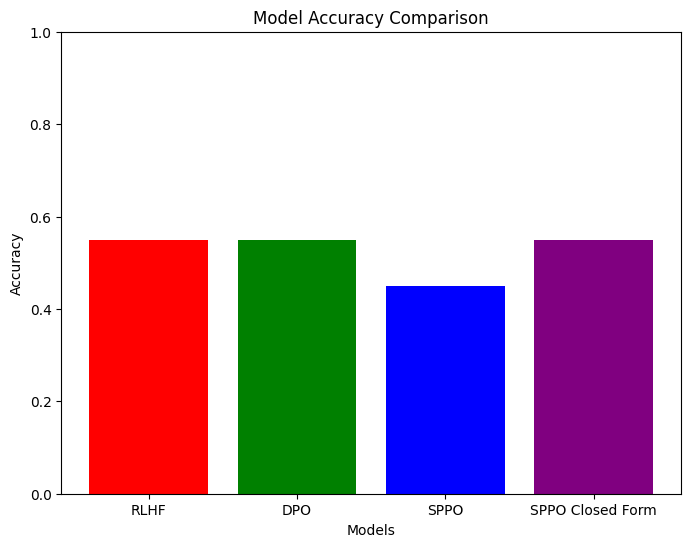

In [45]:
plot_model_accuracies(
    model_names=["RLHF", "DPO", "SPPO", "SPPO Closed Form"],
    accuracies=[rlhf_accuracy, DPO_accuracy, SPPO_accuracy, SPPO_closed_form_accuracy],
    filename="model_accuracies.png"
)